In [1]:
import datetime
import calendar
import warnings

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [2]:
dataframe = pd.read_csv("database.csv", low_memory=False)
dataframe.head()

departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168610            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

In [3]:
dataframe[['departure','return']] =  dataframe[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataframe[["distance", "duration", "temperature"]].describe()

distance     duration  temperature
count 11278850.000 11278850.000 11278850.000
mean      2242.385      783.600       15.637
std       1494.708      795.838        5.495
min         51.000      121.000       -5.200
25%       1121.000      380.000       12.300
50%       1847.000      615.000       16.400
75%       2964.000      991.000       19.300
max       9999.000    17998.000       32.900

In [5]:
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

dataframe[["distance", "duration", "temperature"]].describe()

distance     duration  temperature
count 11278850.000 11278850.000 11278850.000
mean      2242.385      783.600       15.637
std       1494.708      795.838        5.495
min         51.000      121.000       -5.200
25%       1121.000      380.000       12.300
50%       1847.000      615.000       16.400
75%       2964.000      991.000       19.300
max       9999.000    17998.000       32.900

In [19]:
year_2016 = dataframe[(dataframe['departure'] >= '2016-01-01') & (dataframe['departure'] <= '2016-12-31')]
year_2017 = dataframe[(dataframe['departure'] >= '2017-01-01') & (dataframe['departure'] <= '2017-12-31')]
year_2018 = dataframe[(dataframe['departure'] >= '2018-01-01') & (dataframe['departure'] <= '2018-12-31')]
year_2019 = dataframe[(dataframe['departure'] >= '2019-01-01') & (dataframe['departure'] <= '2019-12-31')]
year_2020 = dataframe[(dataframe['departure'] >= '2020-01-01') & (dataframe['departure'] <= '2020-12-31')]

In [18]:
year_list = [year_2016,year_2017,year_2018,year_2019,year_2020]
y = [2016,2017,2018,2019,2020]

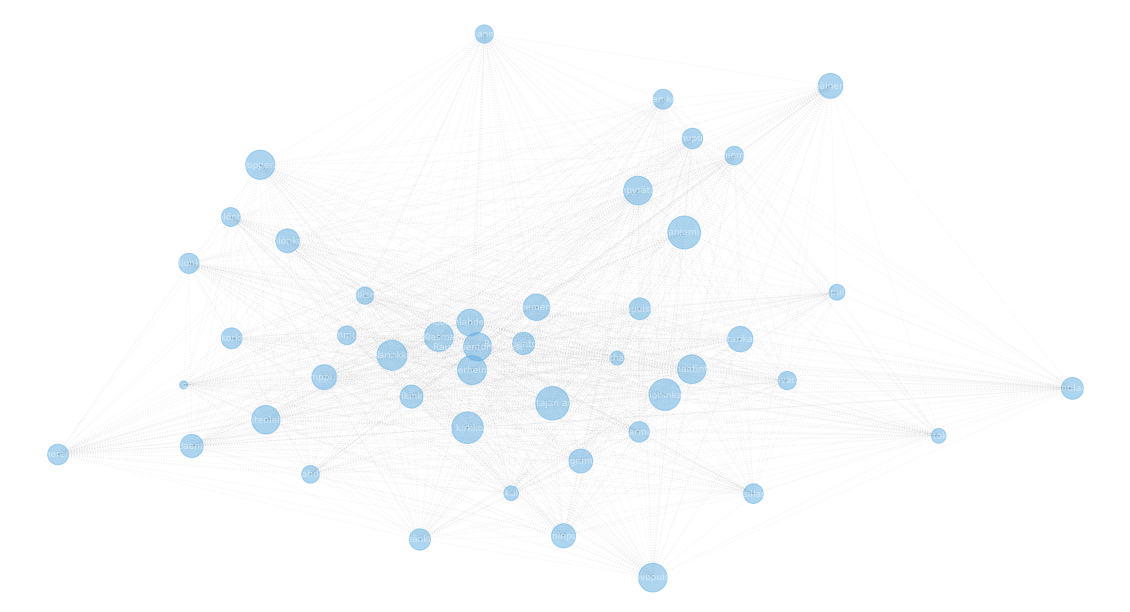

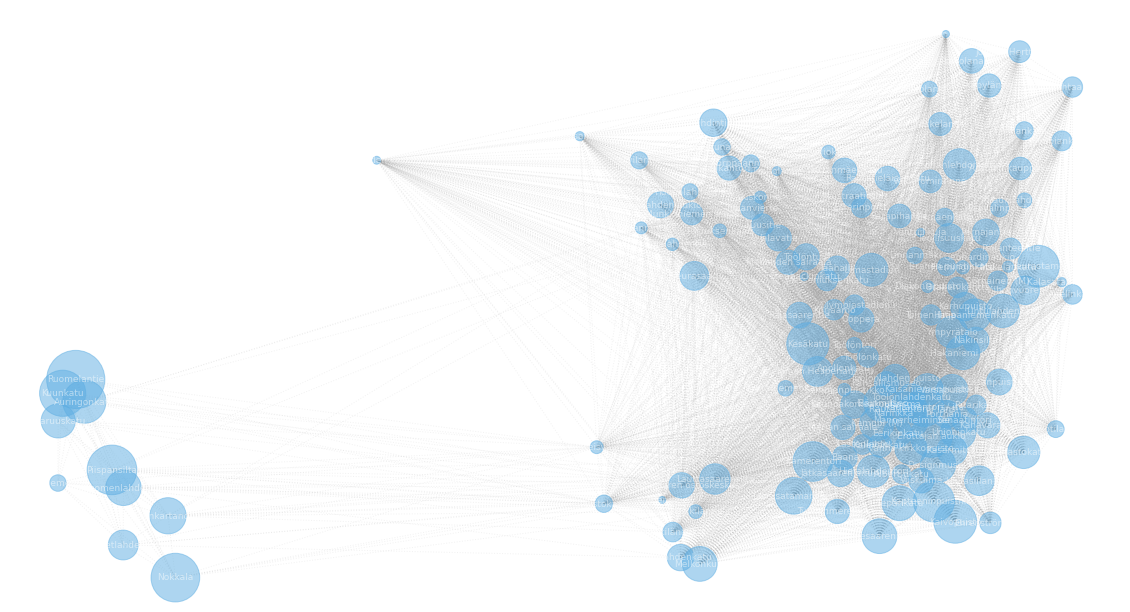

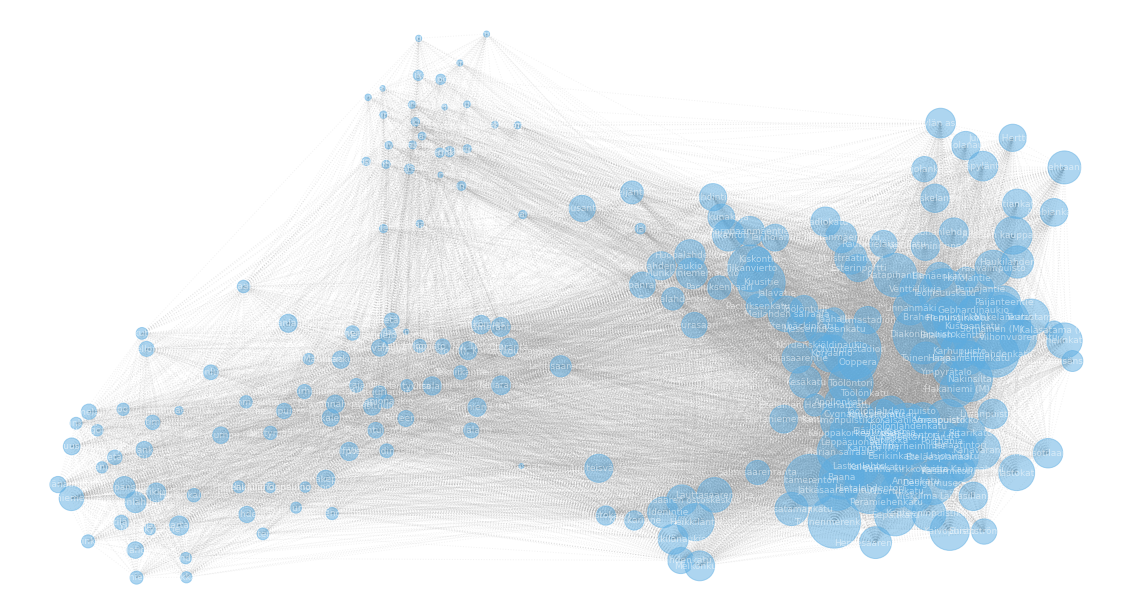

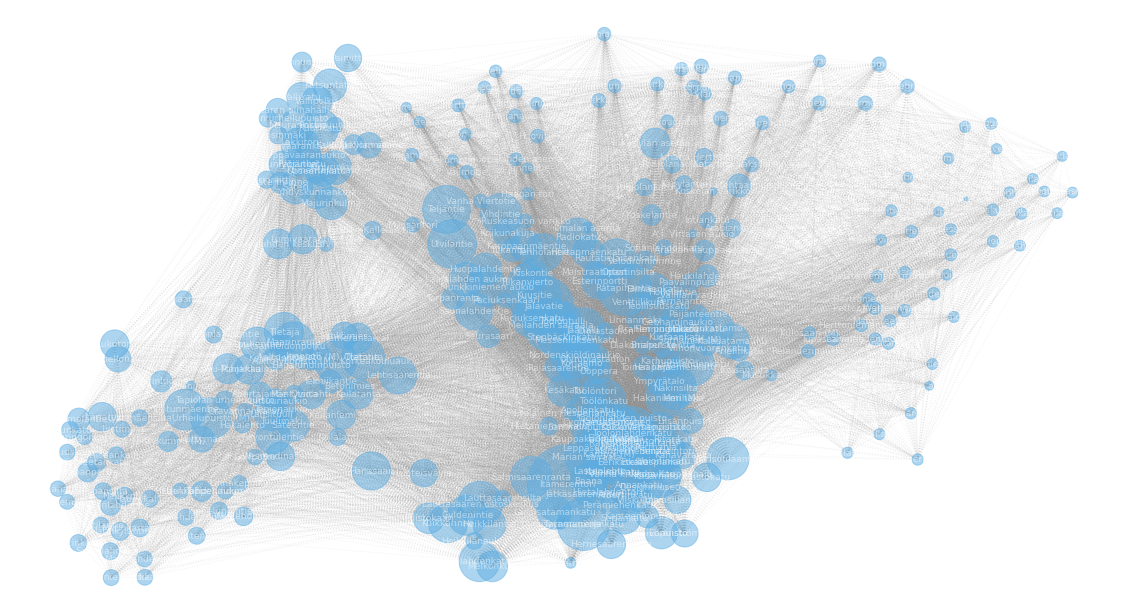

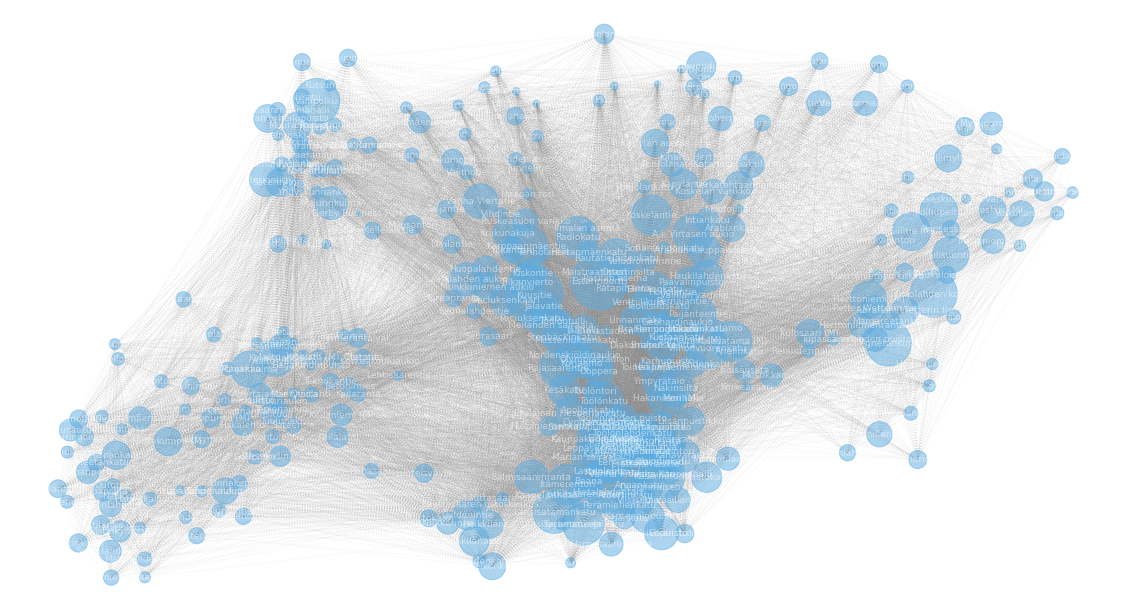

In [15]:
# Covid network
def bikeNetwork(dataframe, year):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])


    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stations  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stations.set_index('name',inplace=True)
    stations["pos"] = list(zip(stations["longitude"].astype(float), stations["latitude"].astype(float)))
    pos = stations.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass
    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    nx.draw_networkx_labels(G=G, pos=G.nodes.data('pos'),font_size=9,font_color='white',alpha=0.5)
    ax.axis('off')

    return G


y16 = bikeNetwork(year_2016,2016)
y17 = bikeNetwork(year_2017,2017)
y18 = bikeNetwork(year_2018,2018)
y19 = bikeNetwork(year_2019,2019)
y20 = bikeNetwork(year_2020,2020)

In [20]:
data_list = [year_2016,year_2017,year_2018,year_2019,year_2020]
network_list = [y16,y17,y18,y19,y20]

for i in range(5):
    print(f"year {y[i]} : {nx.info(network_list[i])}")

year 2016 : Name: 
Type: Graph
Number of nodes: 46
Number of edges: 1081
Average degree:  47.0000
year 2017 : Name: 
Type: Graph
Number of nodes: 142
Number of edges: 8589
Average degree: 120.9718
year 2018 : Name: 
Type: Graph
Number of nodes: 246
Number of edges: 17068
Average degree: 138.7642
year 2019 : Name: 
Type: Graph
Number of nodes: 340
Number of edges: 27708
Average degree: 162.9882
year 2020 : Name: 
Type: Graph
Number of nodes: 347
Number of edges: 29604
Average degree: 170.6282


## Modelling

In [392]:
# Create dicts with centrality measures

degree = nx.degree_centrality(y20)
betweenness = nx.betweenness_centrality(y20)
closeness = nx.closeness_centrality(y20)
eigenvector = nx.eigenvector_centrality(y20)

In [393]:
# Transform dict to pd.df

betweenness = pd.DataFrame.from_dict(betweenness, columns= ["Betweenness"], orient='index' )
#betweenness.index = betweenness["departure_name"]

degree = pd.DataFrame.from_dict(degree, columns= ["Degree"], orient='index' )
#centrality.sort_values('departure_name', ascending = False, inplace = True)

closeness = pd.DataFrame.from_dict(closeness, columns= ["Closeness"], orient='index' )
#degree.sort_values('departure_name', ascending = False, inplace = True)

eigenvector = pd.DataFrame.from_dict(eigenvector, columns= ["Eigenvector"], orient='index' )


In [394]:
trips = year_2020.groupby(['departure_name']).size().reset_index(name = 'number_of_trips')
trips.sort_values('departure_name', ascending = False, inplace = True)
trips.index = trips["departure_name"]

In [395]:
df = pd.concat([trips, betweenness,degree,closeness,eigenvector], axis=1, join="inner")

In [396]:
df.reset_index(drop=True, inplace=True)
df

departure_name  number_of_trips  Betweenness  \
0                               Ympyrätalo            39529        0.003   
1                          Yhdyskunnankuja             3382        0.001   
2                             Westendintie             2649        0.001   
3                           Westendinasema             5147        0.002   
4                         Von Daehnin katu             1542        0.000   
..                                     ...              ...          ...   
342                            Agnetankuja             6725        0.001   
343                   Abraham Wetterin tie             5025        0.001   
344          Aalto-yliopisto (M), Tietotie             4343        0.002   
345  Aalto-yliopisto (M), Korkeakouluaukio            26621        0.006   
346                    A.I. Virtasen aukio             5208        0.001   

     Degree  Closeness  Eigenvector  
0     0.711      0.772        0.075  
1     0.425      0.627        0.036  
2     0.321      0.587        0.021  
3     0.474      0.652        0.038  
4     0.275      0.575        0.024  
..      ...        ...          ...  
342   0.390      0.618        0.038  
343   0.399      0.622        0.039  
344   0.503      0.663        0.042  
345   0.676      0.752        0.060  
346   0.590      0.706        0.065  

[347 rows x 6 columns]

<AxesSubplot:xlabel='Degree', ylabel='number_of_trips'>

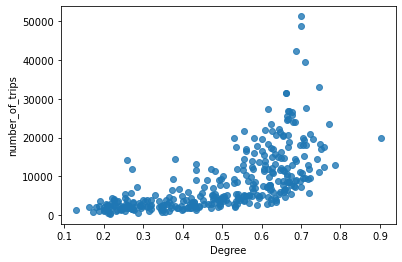

In [397]:
sns.regplot(x="Degree", y="number_of_trips", data=df, fit_reg=False)


<AxesSubplot:xlabel='Betweenness', ylabel='number_of_trips'>

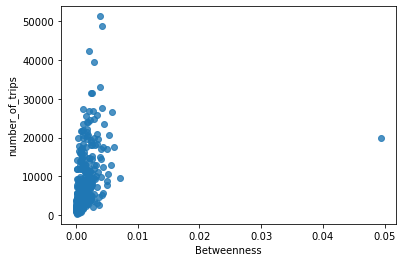

In [398]:
sns.regplot(x="Betweenness", y="number_of_trips", data=df, fit_reg=False)


<AxesSubplot:xlabel='Closeness', ylabel='number_of_trips'>

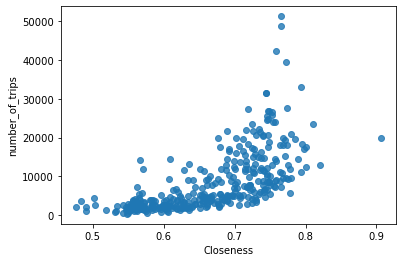

In [101]:
sns.regplot(x="Closeness", y="number_of_trips", data=df, fit_reg=False)


<AxesSubplot:xlabel='Eigenvector', ylabel='number_of_trips'>

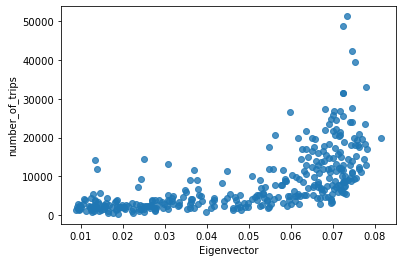

In [102]:
sns.regplot(x="Eigenvector", y="number_of_trips", data=df, fit_reg=False)


In [399]:
# Visualize correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm') 


In [401]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Computing VIF to check multicollinearity if VIF > 5 

# the independent variables set
X = df[['Betweenness', 'Degree', 'Closeness',"Eigenvector"]]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

       feature     VIF
0  Betweenness   1.876
1       Degree 308.908
2    Closeness  52.713
3  Eigenvector 128.606


In [403]:

from sklearn.preprocessing import StandardScaler
df1 = df.copy()

cols_to_norm = ['Betweenness', 'Degree', 'Closeness',"Eigenvector"]

df1[cols_to_norm] = StandardScaler().fit_transform(df1[cols_to_norm])
df1 = pd.DataFrame(df1)

In [404]:
df1

departure_name  number_of_trips  Betweenness  \
0                               Ympyrätalo            39529        0.503   
1                          Yhdyskunnankuja             3382       -0.109   
2                             Westendintie             2649       -0.332   
3                           Westendinasema             5147        0.316   
4                         Von Daehnin katu             1542       -0.439   
..                                     ...              ...          ...   
342                            Agnetankuja             6725       -0.271   
343                   Abraham Wetterin tie             5025       -0.261   
344          Aalto-yliopisto (M), Tietotie             4343        0.297   
345  Aalto-yliopisto (M), Korkeakouluaukio            26621        1.494   
346                    A.I. Virtasen aukio             5208       -0.159   

     Degree  Closeness  Eigenvector  
0     1.294      1.368        1.186  
1    -0.406     -0.501       -0.563  
2    -1.024     -1.007       -1.254  
3    -0.114     -0.182       -0.476  
4    -1.299     -1.170       -1.097  
..      ...        ...          ...  
342  -0.612     -0.616       -0.481  
343  -0.560     -0.559       -0.450  
344   0.058     -0.038       -0.311  
345   1.088      1.109        0.491  
346   0.573      0.518        0.740  

[347 rows x 6 columns]

/Users/giacomo/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


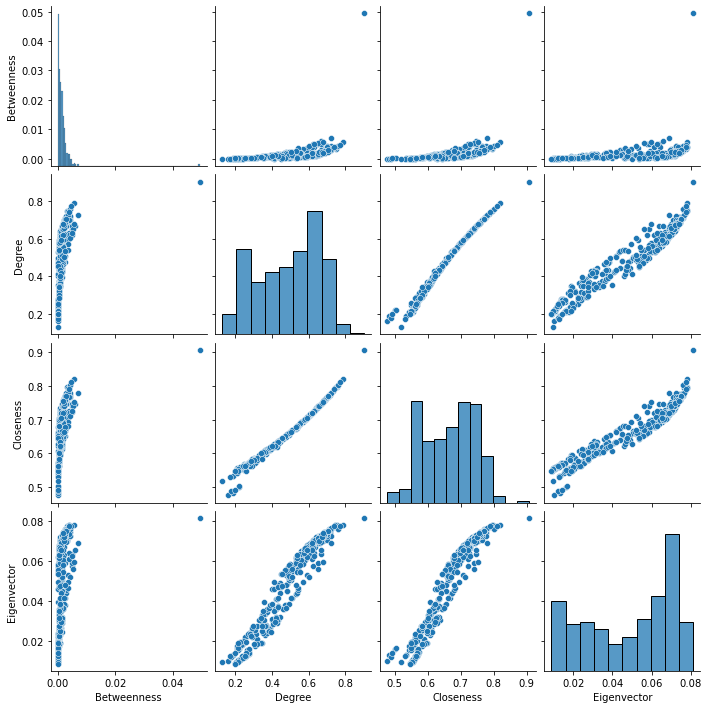

347


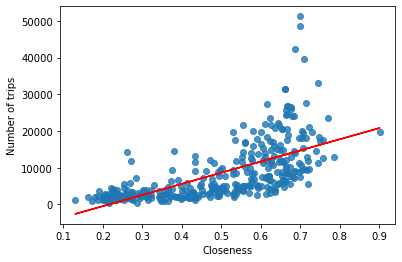

Parameters:
w0: -6540.926973
w1: 30330.198592
R2: 0.411743


In [406]:
from sklearn import linear_model, metrics

from sklearn import preprocessing


#### Some scatter plots
cols = ['Betweenness', 'Degree', 'Closeness', 'Eigenvector']
sns.pairplot(df[cols], size=2.5)
plt.show()

# change to df1 to have normalized values for X 
y = df.iloc[:,1].values  

X = df.iloc[:,[3,]].values

print(X.size)

### Plot 
g = sns.regplot(x=X, y=y, fit_reg=False)




### Linear Regression
reg = linear_model.LinearRegression()
reg.fit(X,y)
plt.plot(X, reg.predict(X), color='red')

### Labels
plt.xlabel('Closeness')
plt.ylabel('Number of trips')
plt.show()

# Coefficients and R2
print('Parameters:')
print('w0: %f'%reg.intercept_)
print('w1: %f'%reg.coef_[0])
print('R2: %f'%metrics.r2_score(y,reg.predict(X)))



## Polynomial Regression 

In [407]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# split into train and test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

242
105


In [408]:
X_train = df_train[['Degree']]
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['number_of_trips']

X_test = df_test[['Degree']]
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['number_of_trips']

In [409]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
# fit multiple polynomial features
degrees = [1, 2, 3,4,5]

y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    

    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

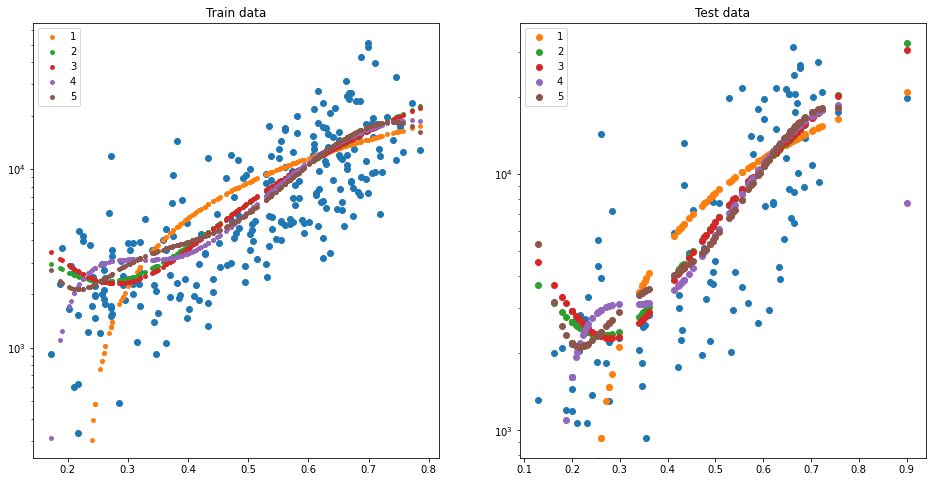

In [410]:
plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [411]:
import sklearn
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.39, test score=0.45
Polynomial degree 2: train score=0.44, test score=0.5
Polynomial degree 3: train score=0.44, test score=0.5
Polynomial degree 4: train score=0.44, test score=0.5
Polynomial degree 5: train score=0.45, test score=0.17


## K fold cross Validation for multiple linear regression

In [412]:
X_train1 = df_train[['Betweenness', 'Degree', 'Closeness', 'Eigenvector']]
#X_train = X_train.values.reshape(-1, 1)
y_train1 = df_train['number_of_trips']

X_test1 = df_test[['Betweenness', 'Degree', 'Closeness', 'Eigenvector']]
#X_test = X_test.values.reshape(-1, 1)
y_test1 = df_test['number_of_trips']

In [413]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train1, y_train1, scoring='r2', cv=5)
scores

array([0.37481103, 0.44233275, 0.29858514, 0.38253963, 0.25668772])

In [414]:
from sklearn.feature_selection import RFE


folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#  specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 4))}]


# perform grid search
#  specify model
lm = LinearRegression()
lm.fit(X_train1, y_train1)
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      


model_cv.fit(X_train1, y_train1)  

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3]}],
             return_train_score=True, scoring='r2', verbose=1)

In [415]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.009         0.004            0.003           0.001   
1          0.004         0.000            0.002           0.000   
2          0.003         0.000            0.002           0.001   

  param_n_features_to_select                       params  split0_test_score  \
0                          1  {'n_features_to_select': 1}              0.236   
1                          2  {'n_features_to_select': 2}              0.432   
2                          3  {'n_features_to_select': 3}              0.432   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0              0.196              0.230              0.263  ...   
1              0.459              0.441              0.219  ...   
2              0.459              0.437              0.214  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0            0.243           0.031                3               0.253   
1            0.408           0.097                1               0.397   
2            0.405           0.098                2               0.397   

   split1_train_score  split2_train_score  split3_train_score  \
0               0.259               0.253               0.243   
1               0.396               0.399               0.471   
2               0.396               0.399               0.472   

   split4_train_score  mean_train_score  std_train_score  
0               0.242             0.250            0.007  
1               0.389             0.411            0.031  
2               0.389             0.411            0.031  

[3 rows x 21 columns]

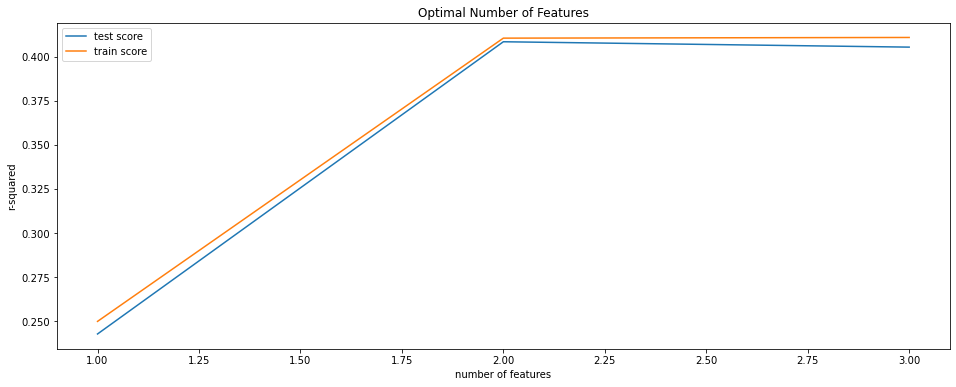

In [416]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [417]:
# final model
n_features_optimal = 2

lm = LinearRegression()
lm.fit(X_train1, y_train1)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train1, y_train1)

# predict prices of X_test
y_pred = lm.predict(X_test1)
r2 = sklearn.metrics.r2_score(y_test1, y_pred)
print(r2)

0.3130675118613646


## Trying some improvements with SVM regression

In [418]:

from sklearn.preprocessing import StandardScaler
df1 = df.copy()

cols_to_norm = ['Betweenness', 'Degree', 'Closeness', 'Eigenvector']

df1[cols_to_norm] = StandardScaler().fit_transform(df1[cols_to_norm])
df1 = pd.DataFrame(df1)

In [419]:
# split into train and test
df_train, df_test = train_test_split(df1, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

242
105


In [420]:
X_train1 = df_train[['Closeness']] # ,"Betweenness","Eigenvector","Closeness"
#X_train = X_train.values.reshape(-1, 1)
y_train1 = df_train['number_of_trips']

X_test1 = df_test[['Closeness']]  #,"Betweenness","Eigenvector","Closeness"
#X_test = X_test.values.reshape(-1, 1)
y_test1 = df_test['number_of_trips']

In [421]:
from sklearn.svm import SVR
from sklearn import svm
from sklearn.model_selection import GridSearchCV

n_samples, n_features = 100, 4
np.random.seed(420)

parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[0.01,0.05,0.1,0.5,1.5, 3,5,10,20],'gamma': [1e-10,1e-8,1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train1,y_train1)
clf.best_params_

y_pred1 = clf.predict(X_test1)

r2 = sklearn.metrics.r2_score(y_test1, y_pred1)
print(r2)





0.15958275063782668
